In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [4]:
df_train.drop(['Name', 'Cabin', 'PassengerId'], axis = 1, inplace = True)
df_test.drop(['Name', 'Cabin', 'PassengerId'], axis = 1, inplace = True)

In [5]:
df_test.isnull().sum().sort_values(ascending=False)

FoodCourt       106
Spa             101
ShoppingMall     98
CryoSleep        93
VIP              93
Destination      92
Age              91
HomePlanet       87
RoomService      82
VRDeck           80
dtype: int64

In [6]:
def fillna(column_name, df_type):
    if df_type == 'train':
        elements = df_train[column_name].dropna().unique()
        proba = [df_train[column_name].value_counts()[i]/len(df_train[column_name].dropna()) for i in elements]
        df_train[column_name].fillna(np.random.choice(a=elements, p = proba), inplace = True)
    else:
        elements = df_test[column_name].dropna().unique()
        proba = [df_test[column_name].value_counts()[i]/len(df_test[column_name].dropna()) for i in elements]
        df_test[column_name].fillna(np.random.choice(a=elements, p = proba), inplace = True)

In [7]:
for column in df_train.isna().sum()[df_train.isna().sum()>0].index:
    fillna(column, 'train')

In [8]:
for column in df_test.isna().sum()[df_test.isna().sum()>0].index:
    fillna(column, 'test')

In [9]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

In [10]:
for i in df_test.columns:
    if df_train[i].dtype == object or df_train[i].dtype == bool:
        label = LabelEncoder()
        df_train[i] = label.fit_transform(df_train[i])
        df_test[i] = label.transform(df_test[i])

In [14]:
scaler = StandardScaler()
model = LogisticRegression()

In [15]:
pipe = Pipeline([('scaler', scaler), ('model', model)])

In [16]:
params = [
    {
        'model__penalty': ['l2'],
        'model__solver': ['lbfgs', 'newton-cg', 'sag', 'newton-cholesky'],
        'model__max_iter': [100, 500, 1000]
    },
    {
        'model__penalty': ['l1'],
        'model__solver': ['liblinear', 'saga'],
        'model__max_iter': [100, 500, 1000]
    },
    {
        'model__penalty': ['elasticnet'],
        'model__solver': ['saga'],
        'model__l1_ratio': [0.15, 0.5, 0.85],
        'model__max_iter': [100, 500, 1000]
    },
    {
        'model__penalty': ['none'],
        'model__solver': ['lbfgs', 'newton-cg', 'sag', 'saga', 'newton-cholesky'],
        'model__max_iter': [100, 500, 1000]
    }
]

In [17]:
final_model = GridSearchCV(pipe, param_grid=params, cv=3, scoring='accuracy', n_jobs=-1)

In [18]:
X_train = df_train.drop('Transported', axis = 1)
X_test = df_test.copy()
y_train = df_train['Transported']

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [20]:
final_model.fit(X_train, y_train)

,estimator,Pipeline(step...egression())])
,param_grid,"[{'model__max_iter': [100, 500, ...], 'model__penalty': ['l2'], 'model__solver': ['lbfgs', 'newton-cg', ...]}, {'model__max_iter': [100, 500, ...], 'model__penalty': ['l1'], 'model__solver': ['liblinear', 'saga']}, ...]"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [21]:
final_model.best_params_

{'model__max_iter': 100, 'model__penalty': 'l2', 'model__solver': 'newton-cg'}

In [22]:
final_model.best_score_

np.float64(0.7861662352602817)

In [23]:
y_pred = final_model.predict(X_val)

In [24]:
print(classification_report(y_pred, y_val))

              precision    recall  f1-score   support

       False       0.74      0.78      0.76       821
        True       0.79      0.76      0.78       918

    accuracy                           0.77      1739
   macro avg       0.77      0.77      0.77      1739
weighted avg       0.77      0.77      0.77      1739



In [40]:
# final_model.best_params_

{'model__l1_ratio': 0.15,
 'model__max_iter': 100,
 'model__penalty': 'l1',
 'model__solver': 'liblinear'}

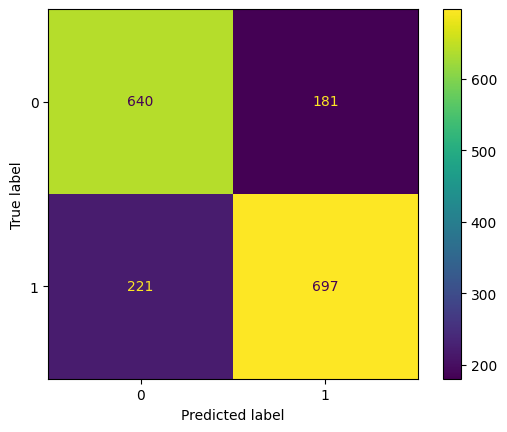

In [25]:
ConfusionMatrixDisplay(confusion_matrix(y_pred, y_val)).plot()

In [26]:
df_sub = pd.read_csv('sample_submission.csv')

In [27]:
finaly_y = final_model.predict(X_test)

In [28]:
df_sub['Transported'] = finaly_y

In [29]:
df_sub.to_csv('sub.csv', index=False, index_label = True)